# Stochastic Parameter Shift Rule:
<u>**By Walid El Maouaki**</u>

In [ ]:
!pip install pennylane
from IPython.display import clear_output
clear_output()

# Parameter-shift rule

In [ ]:
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import numpy as np
from scipy.linalg import expm

np.random.seed(143)
angles = np.linspace(0, 2 * np.pi, 50)
dev = qml.device('default.qubit', wires=2)

In [ ]:
@qml.qnode(dev)
def rotation_circuit(theta):
    qml.RX(theta, wires=0)
    #qml.RY(theta, wires=0)
    return qml.expval(qml.PauliZ(0))

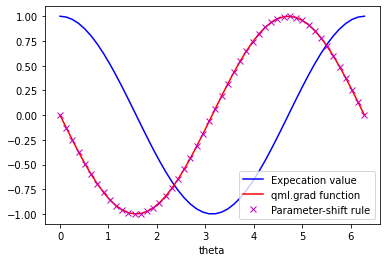

In [ ]:
def param_shift(theta):
    # using the convention u=1/2
    r_plus = rotation_circuit(theta + np.pi / 2)
    r_minus = rotation_circuit(theta - np.pi / 2)
    return 0.5 * (r_plus - r_minus)

gradient = qml.grad(rotation_circuit, argnum=0)

expvals = [rotation_circuit(theta) for theta in angles]
grad_vals = [gradient(theta) for theta in angles]
param_shift_vals = [param_shift(theta) for theta in angles]
plt.plot(angles, expvals, 'b', label="Expecation value")
plt.plot(angles, grad_vals, 'r', label="qml.grad function")
plt.plot(angles, param_shift_vals, 'mx', label="Parameter-shift rule")
plt.xlabel("theta")
plt.legend()
plt.show()

# Stochastic Parameter Shift Rule

# $\hat{U}(\theta)= \exp{i\theta \hat{X}\otimes\hat{Z}}$

## -Differentiate $R_x(\theta)$ gate with respect to $\theta$ :

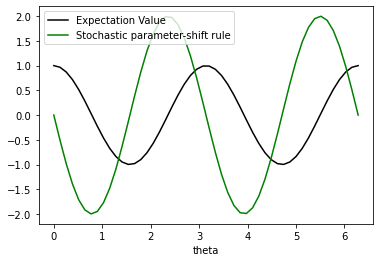

In [ ]:
# First we define some basic Pauli matrices
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

def Generator(theta):
    # the inputs will show up as Pennylane Variable objects;
    # we have to extract their numerical values
    G = theta.val * np.kron(X, Z)
    return G

###### A simple example circuit that contains the cross-resonance gate ######
@qml.qnode(dev)
def crossres_circuit(gate_pars):
    G = Generator(*gate_pars)
    qml.QubitUnitary(expm(-1j * G), wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# Subcircuit implementing the gates necessary for the
# stochastic parameter-shift rule.
# In this example, we will differentiate the first term of
# the circuit X gate (i.e., our variable is theta).
################## stochastic parameter-shift rule steps ##################
def SPSRgates(gate_pars, s, sign):
    G = Generator(*gate_pars)
    # step 1)
    qml.QubitUnitary(expm(1j * (1 - s) * G), wires=[0, 1])
    # step 2)
    qml.QubitUnitary(expm(1j * sign * np.pi / 4 * X), wires=0)
    # step 3)
    qml.QubitUnitary(expm(1j * s * G), wires=[0,1])

# Function which can obtain all expectation vals needed
# for the stochastic parameter-shift rule
########### Function that return the expectation value of first wire ###########
@qml.qnode(dev)
def spsr_circuit(gate_pars, s=None, sign=+1):
    SPSRgates(gate_pars, s, sign)
    return qml.expval(qml.PauliZ(0))


# Obtain r+ and r-
# Even 10 samples gives a good result for this example
################## Psitive value sampling ###################
pos_vals = np.array([[spsr_circuit([theta], s=s, sign=+1)
                      for s in np.random.uniform(size=10)]
                      for theta in angles])
################## Negative value sampling ##################
neg_vals = np.array([[spsr_circuit([theta], s=s, sign=-1)
                      for s in np.random.uniform(size=10)]
                      for theta in angles])

# Plot the results
evals = [crossres_circuit([theta]) for theta in angles]
spsr_vals = (pos_vals - neg_vals).mean(axis=1)
plt.plot(angles, evals, 'black', label="Expectation Value")
plt.plot(angles, spsr_vals, 'green', label="Stochastic parameter-shift rule")
plt.xlabel("theta")
plt.legend()
plt.show()

The black line is the expectation value of the unitary, whereas the green one is the expectation valueof the derived unitary.

$\rightarrow$ We can see that these have the functional form $- \sin(\theta)$, the expected derivative of $\cos(\theta)$
## -Differentiating of Z gate with respect to $\theta$

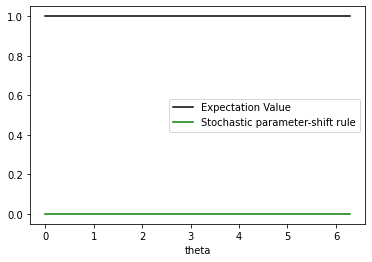

In [ ]:
# First we define some basic Pauli matrices
# I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

def Generator(theta):
    # the inputs will show up as Pennylane Variable objects;
    # we have to extract their numerical values
    G = theta.val * np.kron(X, Z)
    return G

# A simple example circuit that contains the cross-resonance gate
@qml.qnode(dev)
def crossres_circuit(gate_pars):
    G = Generator(*gate_pars)
    qml.QubitUnitary(expm(-1j * G), wires=[0, 1])
    return qml.expval(qml.PauliZ(1))

# Subcircuit implementing the gates necessary for the
# stochastic parameter-shift rule.
# In this example, we will differentiate the first term of
# the circuit (i.e., our variable is theta1).
def SPSRgates(gate_pars, s, sign):
    G = Generator(*gate_pars)
    # step 1)
    qml.QubitUnitary(expm(1j * (1 - s) * G), wires=[0, 1])
    # step 2)
    qml.QubitUnitary(expm(1j * sign * np.pi / 4 * Z), wires=1)
    # step 3)
    qml.QubitUnitary(expm(1j * s * G), wires=[0,1])

# Function which can obtain all expectation vals needed
# for the stochastic parameter-shift rule
@qml.qnode(dev)
def spsr_circuit(gate_pars, s=None, sign=+1):
    SPSRgates(gate_pars, s, sign)
    return qml.expval(qml.PauliZ(1))

# Fix the other parameters of the gate
# theta2, theta3 = -0.15, 1.6

# Obtain r+ and r-
# Even 10 samples gives a good result for this example
pos_vals = np.array([[spsr_circuit([theta], s=s, sign=+1)
                      for s in np.random.uniform(size=10)]
                      for theta in angles])
neg_vals = np.array([[spsr_circuit([theta], s=s, sign=-1)
                      for s in np.random.uniform(size=10)]
                      for theta in angles])

# Plot the results
evals = [crossres_circuit([theta]) for theta in angles]
spsr_vals = (pos_vals - neg_vals).mean(axis=1)
plt.plot(angles, evals, 'black', label="Expectation Value")
plt.plot(angles, spsr_vals, 'green', label="Stochastic parameter-shift rule")
plt.xlabel("theta")
plt.legend()
plt.show()

$\rightarrow$ Differentiating a constance function gives zero.

$\hat{U}_{CR}(\theta_1, \theta_2, \theta_3)
                   = \exp\left[ i(\theta_1\hat{X}\otimes\hat{\mathbf{I}} -
                                  \theta_2\hat{Z}\otimes\hat{X} +
                                  \theta_3\hat{\mathbf{I}}\otimes\hat{X}
                               ) \right].$
                               
## Differentiating with respect of $\theta_1$:

---



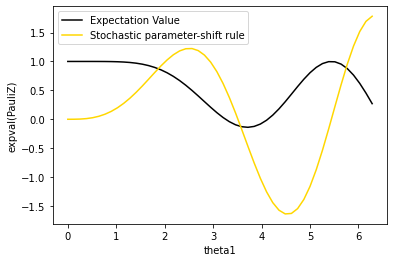

In [ ]:
# First we define some basic Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

def Generator(theta1, theta2, theta3):
    # the inputs will show up as Pennylane Variable objects;
    # we have to extract their numerical values
    G = theta1.val * np.kron(X, I) - \
        theta2.val * np.kron(Z, X) + \
        theta3.val * np.kron(I, X)
    return G

# A simple example circuit that contains the cross-resonance gate
@qml.qnode(dev)
def crossres_circuit(gate_pars):
    G = Generator(*gate_pars)
    qml.QubitUnitary(expm(-1j * G), wires=[0, 1])
    return qml.expval(qml.PauliZ(1))

# Subcircuit implementing the gates necessary for the
# stochastic parameter-shift rule.
# In this example, we will differentiate the first term of
# the circuit (i.e., our variable is theta1).
def SPSRgates(gate_pars, s, sign):
    G = Generator(*gate_pars)
    # step a)
    qml.QubitUnitary(expm(1j * (1 - s) * G), wires=[0, 1])
    # step b)
    qml.QubitUnitary(expm(1j * sign * np.pi / 4 * X), wires=1)
    # step c)
    qml.QubitUnitary(expm(1j * s * G), wires=[0,1])

# Function which can obtain all expectation vals needed
# for the stochastic parameter-shift rule
@qml.qnode(dev)
def spsr_circuit(gate_pars, s=None, sign=+1):
    SPSRgates(gate_pars, s, sign)
    return qml.expval(qml.PauliZ(1))

# Fix the other parameters of the gate
# theta3, theta1 = -0.15, 1.6
theta3, theta1 = -np.pi, np.pi

# Obtain r+ and r-
# Even 10 samples gives a good result for this example
pos_vals = np.array([[spsr_circuit([theta1, theta2, theta3], s=s, sign=+1)
                      for s in np.random.uniform(size=10)]
                      for theta2 in angles])
neg_vals = np.array([[spsr_circuit([theta1, theta2, theta3], s=s, sign=-1)
                      for s in np.random.uniform(size=10)]
                      for theta2 in angles])

# Plot the results
evals = [crossres_circuit([theta1, theta2, theta3]) for theta2 in angles]
spsr_vals = (pos_vals - neg_vals).mean(axis=1)
plt.plot(angles, evals, 'black', label="Expectation Value")
plt.plot(angles, spsr_vals, 'gold', label="Stochastic parameter-shift rule")
plt.xlabel("theta1")
plt.ylabel("expval(PauliZ)")
plt.legend()
plt.show()

# Reference:
https://pennylane.ai/qml/demos/tutorial_stochastic_parameter_shift.html